## Проект по детекции эмоций по аудио

In [87]:
import pandas as pd
import numpy as np
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio, display

import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

import joblib

#### Загрузка датасета и проверка классов

In [2]:
data_path = 'C:\projects\Python\ml\DAILY_WORK\project_audio\dataset'

In [3]:
for files in os.listdir(data_path):
    print(files)

OAF_angry
OAF_disgust
OAF_Fear
OAF_happy
OAF_neutral
OAF_Pleasant_surprise
OAF_Sad
YAF_angry
YAF_disgust
YAF_fear
YAF_happy
YAF_neutral
YAF_pleasant_surprised
YAF_sad


#### Распределение количества данных внутри каждого класса

In [4]:
data_amount_info = {}
data_duration_info = {}

for emotion in os.listdir(data_path):
    print(emotion[4:])
    emotion_path = os.path.join(data_path, files)
    for file in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, file)
        if file.endswith(".wav"):
            duration = librosa.get_duration(path=file_path)  # продолжительность файла
            data_duration_info[emotion] = data_duration_info.get(emotion, 0) + duration  # добавляем продолжительность к нужной эмоции

            data_amount_info[emotion] = data_amount_info.get(emotion, 0) + 1  # считаем количество файлов
        else:
            print('Найден файл с некорректным разрешением')

angry
disgust
Fear
happy
neutral
Pleasant_surprise
Sad
angry
disgust
fear
happy
neutral
pleasant_surprised
sad


Заметим, что среди классов есть повторяющиеся. Дальше узнаем в чем разница

In [5]:
# средняя продолжительность звукового фрагмента данных
for emotion in data_duration_info.keys():
    data_duration_info[emotion] /= data_amount_info[emotion]

In [6]:
data_amount_info

{'OAF_angry': 200,
 'OAF_disgust': 200,
 'OAF_Fear': 200,
 'OAF_happy': 200,
 'OAF_neutral': 200,
 'OAF_Pleasant_surprise': 200,
 'OAF_Sad': 200,
 'YAF_angry': 200,
 'YAF_disgust': 200,
 'YAF_fear': 200,
 'YAF_happy': 200,
 'YAF_neutral': 200,
 'YAF_pleasant_surprised': 200,
 'YAF_sad': 200}

In [7]:
data_duration_info

{'OAF_angry': 2.2683728598345207,
 'OAF_disgust': 2.2683728598345207,
 'OAF_Fear': 2.2683728598345207,
 'OAF_happy': 2.2683728598345207,
 'OAF_neutral': 2.2683728598345207,
 'OAF_Pleasant_surprise': 2.2683728598345207,
 'OAF_Sad': 2.2683728598345207,
 'YAF_angry': 2.2683728598345207,
 'YAF_disgust': 2.2683728598345207,
 'YAF_fear': 2.2683728598345207,
 'YAF_happy': 2.2683728598345207,
 'YAF_neutral': 2.2683728598345207,
 'YAF_pleasant_surprised': 2.2683728598345207,
 'YAF_sad': 2.2683728598345207}

В датасете одинаковое количество данных на каждую эмоцию и одинаковая средняя длина записи

#### Демонстрация случайных записей

In [91]:
for emotion in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion)
    k = np.random.randint(0, data_amount_info[emotion])
    for i, file in enumerate(os.listdir(emotion_path)):
        if i < k: continue  # для того, чтобы взять случайный фрагмент датасета
        file_path = os.path.join(emotion_path, file)
        if file.endswith(".wav"):
            print(emotion[4:])
            display(Audio(file_path))
            break

angry


disgust


Fear


happy


neutral


Pleasant_surprise


Sad


angry


disgust


fear


happy


neutral


pleasant_surprised


sad


Проанализировав записи, становится понятно, что разница между одинаковыми классами в том, что их произносят разные люди. Соответственно, их можно поместить в один класс в будущем

#### Построение спектрограмм и waveplot до обработки

In [72]:
data, sr = librosa.load("C:\projects\Python\ml\DAILY_WORK\project_audio\dataset\OAF_angry\OAF_bath_angry.wav")

In [149]:
def create_waveplot(data, sr, e, ax=None):
    if ax is not None:
        plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    return librosa.display.waveshow(data, sr=sr, ax=ax, color='#5EE8AC')

def create_spectrogram(data, sr, e, ax=None, **kwargs):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    if ax is not None:
        plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    return librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax, cmap='Accent', **kwargs)

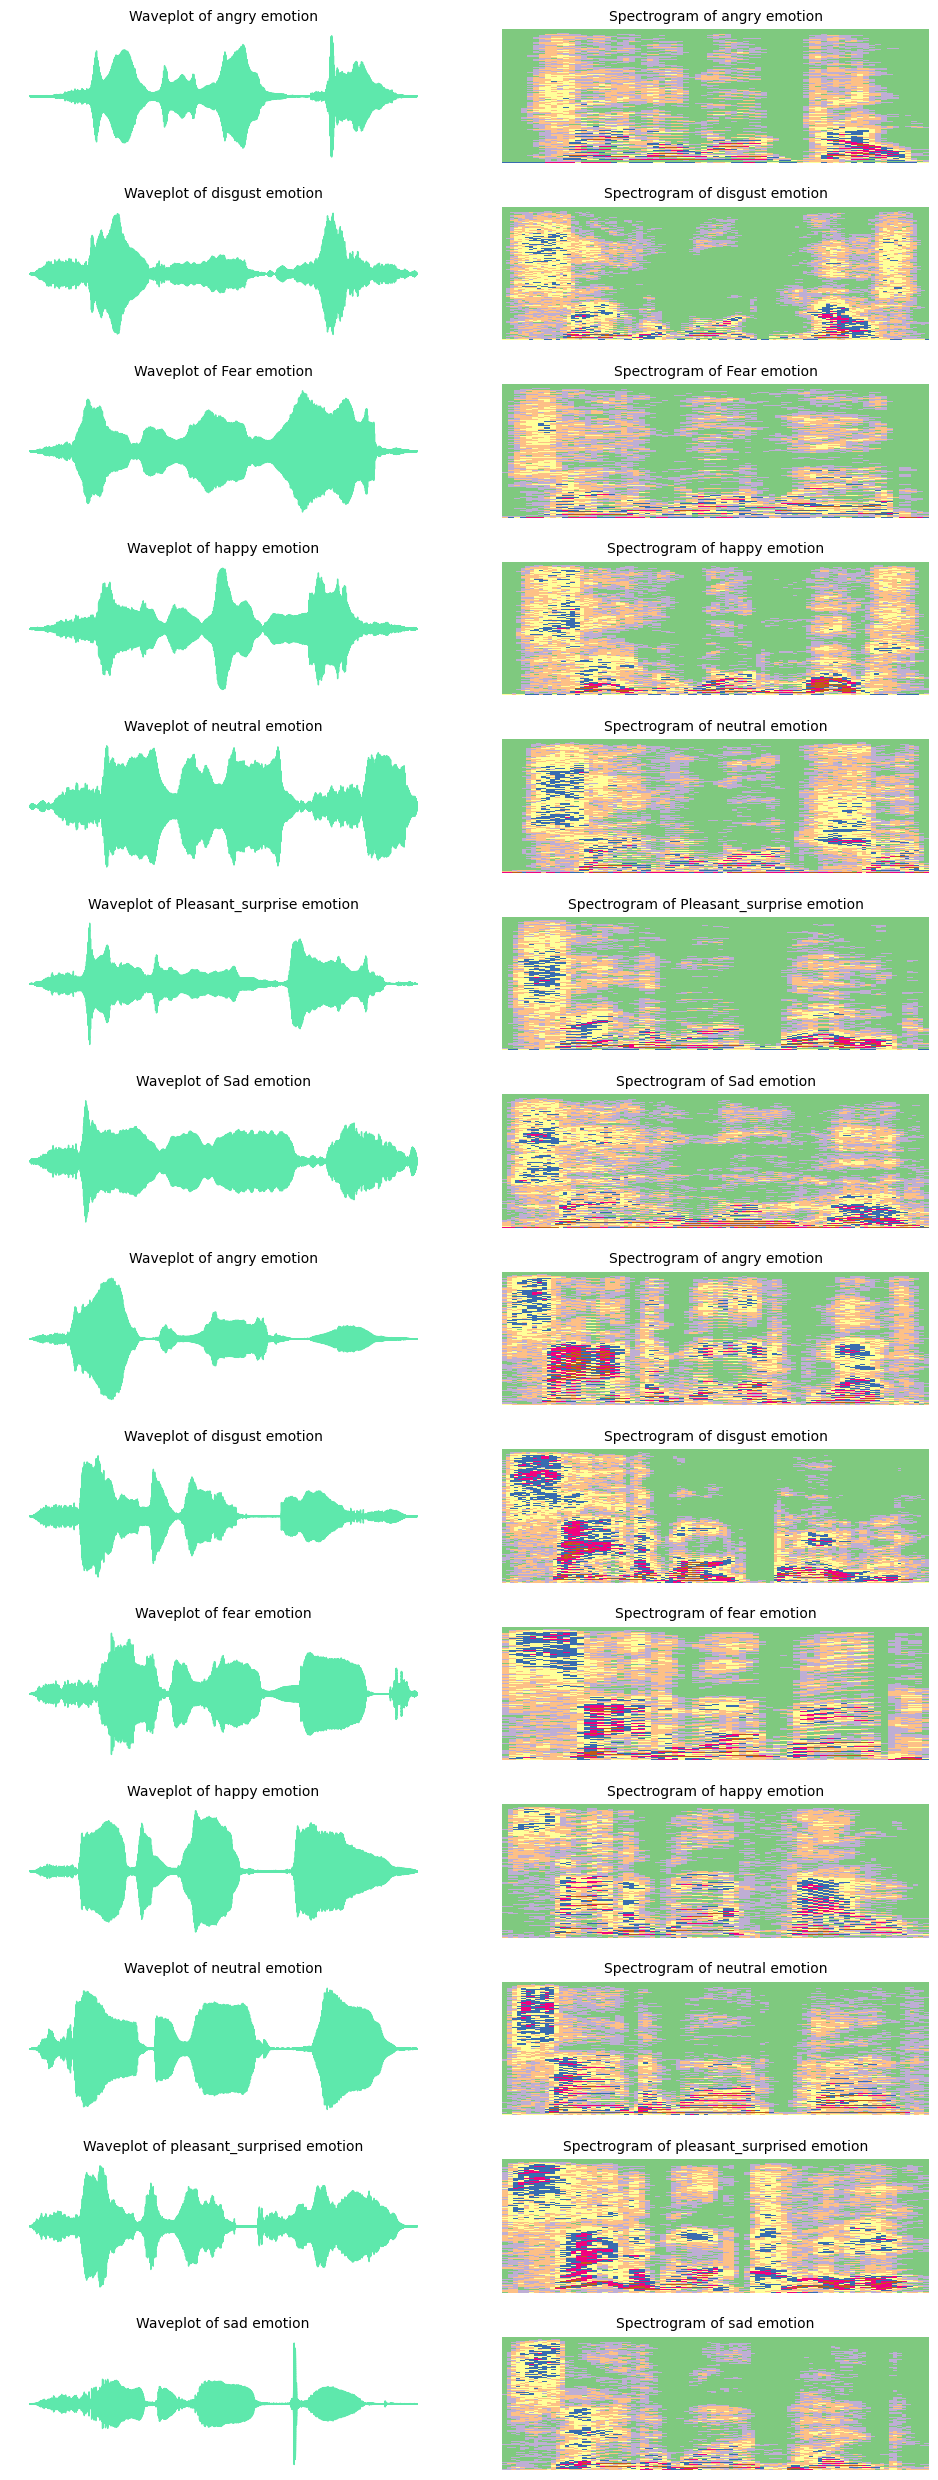

In [77]:
fig, axes = plt.subplots(len(data_amount_info), 2)
fig.set_size_inches(10, 25)
fig.tight_layout()

for emotion, ax in zip(os.listdir(data_path), axes):
    emotion_path = os.path.join(data_path, emotion)
    k = np.random.randint(0, data_amount_info[emotion])
    for i, file in enumerate(os.listdir(emotion_path)):
        if i < k: continue  # для того, чтобы взять случайный фрагмент датасета
        file_path = os.path.join(emotion_path, file)
        if file.endswith(".wav"):
            data, sr = librosa.load(file_path)
            create_waveplot(data, sr, emotion, ax=ax[0])
            create_spectrogram(data, sr, emotion, ax=ax[1])
            ax[0].set_title(f'Waveplot of {emotion[4:]} emotion', size=10)
            ax[0].axis('off')
            ax[1].axis('off')
            ax[1].set_title(f'Spectrogram of {emotion[4:]} emotion', size=10)
            break

#### Преобразование датасета в спектрограммы и объединение классов

In [156]:
def create_dataset(path_from, path_to):
    k = -1
    for emotion in os.listdir(path_from):
        print(emotion[4:].lower())
        final_path = f'{path_to}/{emotion[4:].lower()}'
        if not os.path.exists(final_path):
            os.mkdir(final_path)
        emotion_path = os.path.join(data_path, emotion)
        for file in os.listdir(emotion_path):
            k += 1

            file_path = os.path.join(emotion_path, file)
            data, sr = librosa.load(file_path)

            '''fig = plt.Figure()
            ax = fig.add_subplot(111)
            ax.axis('off')
            spect = create_spectrogram(data, sr, emotion, ax=ax)
            
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0, transparent=True)'''

            plt.figure(figsize=(10, 6))
            plt.axis('off')

            create_spectrogram(data, sr, emotion[4:], ax=None)

            plt.savefig(f'{final_path}/{emotion[4:]}_{k}', bbox_inches='tight', pad_inches=0, transparent=True)
            plt.close()

Вывод каждой эмоции по 2 раза, потому что, как говорилось ранее, в датасете одинаковые эмоции озвучены двумя людьми

In [158]:
create_dataset(data_path, "C:\projects\Python\ml\DAILY_WORK\project_audio\dataset_new")

angry
disgust
fear
happy
neutral
pleasant_surprise
sad
angry
disgust
fear
happy
neutral
pleasant_surprised
sad


In [160]:
data_path_new = "C:\projects\Python\ml\DAILY_WORK\project_audio\dataset_new"

### Попытка построить нейронку

In [162]:
image_size = (775, 462)

In [164]:
training_set, validation_set = keras.utils.image_dataset_from_directory(
    directory=data_path_new,
    batch_size=16,
    validation_split=0.2,
    subset='both',
    seed=42,
    image_size=image_size
)

Found 2800 files belonging to 8 classes.
Using 2240 files for training.
Using 560 files for validation.


In [165]:
label_names = training_set.class_names
label_names

['angry',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'pleasant_surprise',
 'pleasant_surprised',
 'sad']

In [166]:
input_shape = next(iter(training_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names)

Input shape: (775, 462, 3)


In [172]:
model = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=input_shape), 

        tf.keras.layers.Resizing(64, 64), 
        tf.keras.layers.Normalization(), 
          
        tf.keras.layers.Conv2D(64, 3, activation='relu'), 
        # tf.keras.layers.Conv2D(128, 3, activation='relu'), 
        tf.keras.layers.MaxPooling2D(), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Flatten(), 
          
        # tf.keras.layers.Dense(256, activation='relu'), 
        # tf.keras.layers.Dropout(0.5), 
          
        tf.keras.layers.Dense(num_labels, activation='softmax')
])

In [173]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'] 
)

In [174]:
epochs = 10
verbose = True

monitor = 'val_loss'
min_delta = 0.01
patience = 3

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose)]

In [175]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
140/140 [==============================] - 19s 134ms/step - loss: 87.7287 - accuracy: 0.5335 - val_loss: 0.4963 - val_accuracy: 0.8482
Epoch 2/10
140/140 [==============================] - 17s 118ms/step - loss: 0.4085 - accuracy: 0.8790 - val_loss: 0.3852 - val_accuracy: 0.9107
Epoch 3/10
140/140 [==============================] - 17s 119ms/step - loss: 0.2320 - accuracy: 0.9415 - val_loss: 0.1567 - val_accuracy: 0.9607
Epoch 4/10
140/140 [==============================] - 17s 119ms/step - loss: 0.2062 - accuracy: 0.9491 - val_loss: 0.2644 - val_accuracy: 0.9339
Epoch 5/10
140/140 [==============================] - 17s 121ms/step - loss: 0.2725 - accuracy: 0.9375 - val_loss: 0.2408 - val_accuracy: 0.9500
Epoch 6/10
140/140 [==============================] - 18s 126ms/step - loss: 0.1940 - accuracy: 0.9576 - val_loss: 0.3459 - val_accuracy: 0.9411
Epoch 6: early stopping


In [179]:
def training_analyze(epochs: int, acc, loss, val_acc=None, val_loss=None,
                     figsize=(6, 6), fontsize=12):
    """Анализ результата тренировки"""
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc: plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xticks(epochs_range)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=fontsize)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss: plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xticks(epochs_range)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=fontsize)

    plt.show()

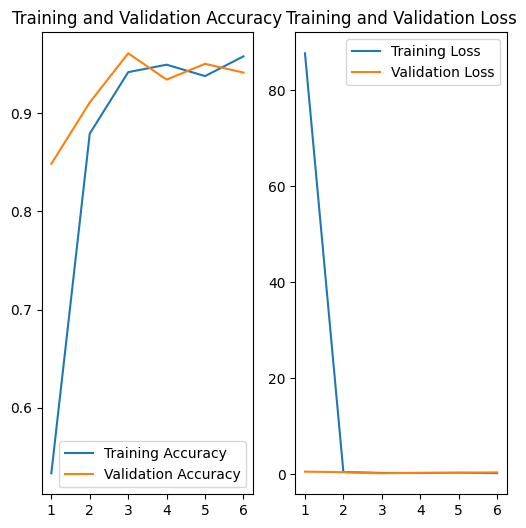

In [180]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

training_analyze(6, acc, loss, val_acc, val_loss)